In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
drive  sample_data


In [4]:
ls

drive/  sample_data/


In [5]:
!mkdir Rakuten

In [6]:
cd '/content/Rakuten'

/content/Rakuten


In [7]:
!cp  '/content/drive/My Drive/Rakuten/image.zip' './'

In [8]:
!ls

image.zip


In [9]:
pwd

'/content/Rakuten'

In [10]:
mkdir models data

In [11]:
cd './Rakuten'

[Errno 2] No such file or directory: './Rakuten'
/content/Rakuten


In [12]:
!unzip  ./image.zip

Streaming output truncated to the last 5000 lines.
  inflating: image/image_training/image_941622041_product_207151319.jpg  
  inflating: image/image_training/image_941622046_product_207151571.jpg  
  inflating: image/image_training/image_941622048_product_207151338.jpg  
  inflating: image/image_training/image_941622055_product_207151480.jpg  
  inflating: image/image_training/image_941622057_product_207151296.jpg  
  inflating: image/image_training/image_941622063_product_207151539.jpg  
  inflating: image/image_training/image_941622065_product_207151527.jpg  
  inflating: image/image_training/image_941622067_product_207151563.jpg  
  inflating: image/image_training/image_941622071_product_207151331.jpg  
  inflating: image/image_training/image_941622073_product_207151492.jpg  
  inflating: image/image_training/image_941622084_product_207151508.jpg  
  inflating: image/image_training/image_941622086_product_207151543.jpg  
  inflating: image/image_training/image_941622094_product_207

In [13]:
cp '/content/drive/My Drive/Rakuten/models/RESNET_baseline_model.pt' models

In [14]:
cd '../'

/content


In [15]:
# import os
# print(len(os.listdir('/content/Rakuten/image/image_training')))

In [17]:
pwd

'/content'

In [26]:
# !cp '/content/drive/My Drive/Rakuten/data/NewTest.csv' data 
!cp '/content/drive/My Drive/Rakuten/data/NewTraining.csv' data 
!cp '/content/drive/My Drive/Rakuten/data/catalog_english_taxonomy.tsv' data 
!cp '/content/drive/My Drive/Rakuten/data/Y_train.tsv' data 

In [19]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [20]:
#cd '/content/drive/My Drive/Rakuten'


In [21]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=111238bcd0371d2b63c70d9d8b0e7e63ed1b6af489f54eb37d304cd60c97d40c
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [22]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
import random
from google.colab import drive
from tqdm._tqdm_notebook import tqdm_notebook
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [23]:
image_path = '/content/Rakuten/image/'
data_path = '/content/Rakuten/data'

image_data_path = image_path

In [27]:
class SigirPreprocess():

  def __init__(self, text_data_path):
    
        self.text_data_path = text_data_path
        self.train = None # Merged X_train and Y_train
        self.dict_code_to_id = {}
        self.dict_id_to_code = {}
        self.list_tags = {} #unique type code
        self.sentences = []
        self.labels = []
        self.text_col = None
        self.X_test = None

  def prepare_data(self):
        
        #loading the Merged, preprocessed text data and test data
        train = pd.read_csv(self.text_data_path+"/NewTraining.csv")
        # new_train =  train[train['Description'] != " "]
        # new_train = new_train[new_train['Description'].notna()]
        self.train = train

        
  def get_sentences(self, text_col, remove_null_rows=True):

       #get values of a specific column
        self.text_col = text_col        

        new_train = self.train.copy()  
        self.sentences = new_train[text_col].values
        self.labels = new_train['labels'].values


  # def prepare_test(self, text_col):
    
  #       X_test = pd.read_csv(self.text_data_path + "/NewTest.csv")
  #       self.X_test = X_test
  #       X_test['title_desc'] = X_test['Title'] + " " + X_test['Description']
  #       self.test_sentences = X_test[text_col].values
  #       return self.test_sentences
        

In [33]:
#Load train and test data (test for specific column)

text_col = 'Description'

max_len = 256

num_classes = 27

Preprocess = SigirPreprocess(data_path)
Preprocess.prepare_data()
train = Preprocess.train
print("Trian:  ", len(Preprocess.train))


Preprocess.get_sentences(text_col)
print("Labels: ", len(Preprocess.labels))

# X_test = Preprocess.prepare_test(text_col)
# print("Test:   ", len(Preprocess.X_test))

Trian:   55025
Labels:  55025


In [34]:
def get_img_path(img_id, prd_id, path):
    
    pattern = 'image'+'_'+str(img_id)+'_'+'product'+'_'+str(prd_id)+'.jpg'
    return path + pattern

In [ ]:
# train_img = train[['Image_id','Product_id','labels','product']]

# train_img['image_path'] = Preprocess.train.progress_apply(lambda x: get_img_path(x['Image_id'], x['Product_id'],
#                                                       path = os.path.join(image_data_path, 'image_training/')),axis=1)

# # X_test['image_path'] = X_test.progress_apply(lambda x: get_img_path(x['Image_id'],x['Product_id'],
# #                                                       path= os.path.join(image_data_path, 'image_test/image_test_task1_phase1/')),axis=1)

# train_df, val_df, _, _ = train_test_split(train_img, train_img['labels'], 
#                                            random_state=2020,
#                                            test_size = 0.1,
#                                            stratify=train_img['labels'])


In [35]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

#  train 65%
#  validation 15%
#  test 20%
# (original training) =>  train, test => 80, 20  val_size = 0.2
# (train) => train, val =>  85, 15   val_size = 0.15 


train_img = train[['Image_id','Product_id','labels','product']]

train_img['image_path'] = Preprocess.train.progress_apply(lambda x: get_img_path(x['Image_id'], x['Product_id'],
                                                      path = os.path.join(image_data_path, 'image_training/')),axis=1)




tr_df, val_df, tr_labels, val_labels = train_test_split(train_img, train_img['labels'], 
                                           random_state=2020,
                                           test_size = 0.2,
                                           stratify=train_img['labels'])


train_df, test_df, train_labels, test_labels = train_test_split(tr_df, tr_labels, 
                                           random_state=2020,
                                           test_size = 0.15,
                                           stratify=tr_labels)


print("Train: ", len(train_df))
print("Val:   ", len(val_df))
print("Test:  ", len(test_df))
print ("")


Train:  37417
Val:    11005
Test:   6603



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
train_img.isna().sum()

# Transfer Learning with PyTorch

In [36]:
!pip install torchsummary

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import os
import copy
from torchsummary import summary
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [38]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = num_classes

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
# feature_extract = True

# Data Augmentation

The transform **RandomResizedCrop** crops the input image by a random size (within a scale range of 0.8 to 1.0 of the original size and a random aspect ratio in the default range of 0.75 to 1.33 ). 
The crop is then resized to 256×256.

**RandomRotation** rotates the image by an angle randomly chosen between -15 to 15 degrees.

**RandomHorizontalFlip** randomly flips the image horizontally with a default probability of 50%.

**CenterCrop** crops an 224×224 image from the center.

**ToTensor** converts the PIL Image which has values in the range of 0-255 to a floating point Tensor and normalizes them to a range of 0-1, by dividing it by 255.

**Normalize** takes in a 3 channel Tensor and normalizes each channel by the input mean and standard deviation for the channel. Mean and standard deviation vectors are input as 3 element vectors. Each channel in the tensor is normalized as T = (T – mean)/(standard deviation)

In [39]:
input_size = 224 # for Resnt
# Applying Transforms to the Data

image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Data Loading

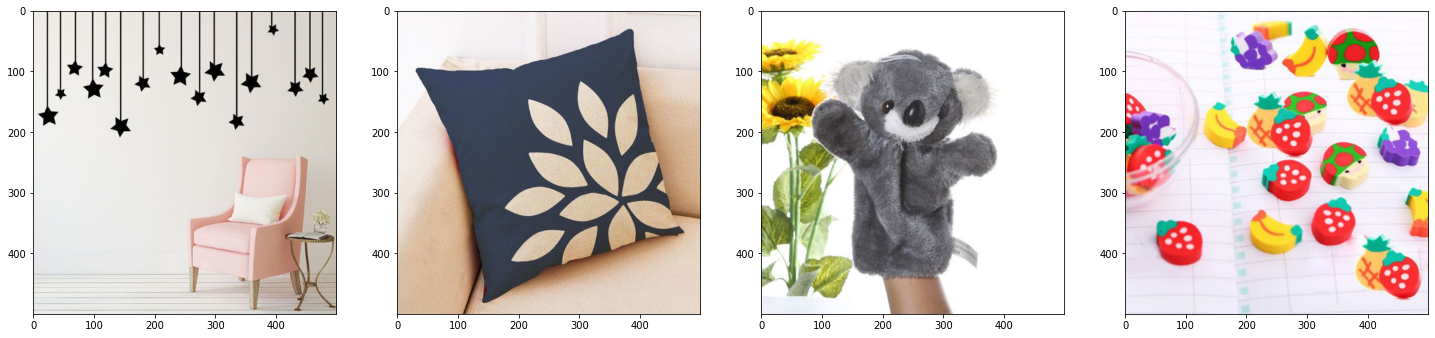

In [40]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

path1 = os.path.join(image_data_path, 'image_test/image_test_task1_phase1/image_1254468067_product_3861761234.jpg')

path2 = os.path.join(image_data_path, 'image_test/image_test_task1_phase1/image_1273327522_product_3992562367.jpg')

path3 = os.path.join(image_data_path, 'image_test/image_test_task1_phase1/image_1282357991_product_4056050830.jpg')

path4 = os.path.join(image_data_path, 'image_test/image_test_task1_phase1/image_1307372185_product_4171236187.jpg')


plt.figure(figsize=(25,25))

plt.subplot(1,4,1)
plt.imshow(plt.imread(path1))

plt.subplot(1,4,2)
plt.imshow(plt.imread(path2))

plt.subplot(1,4,3)
plt.imshow(plt.imread(path3))

plt.subplot(1,4,4)
plt.imshow(plt.imread(path4))

#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [41]:
# Load the Data

from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    
    def __init__(self,df, transform=None, mode='train'):
        self.df = df
        self.transform=transform
        self.mode=mode
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        
        im_path = self.df.iloc[idx]['image_path']
        #img = cv2.imread(im_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = plt.imread(im_path)
        #img = plt.imshow(img)
        img=Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        img=img.cuda()
        
        if self.mode=='test':
            return img
        else:
            labels = torch.tensor(self.df.iloc[idx]['labels']).cuda()
            return img, labels

In [42]:
train_dataset = ImageDataset(df = train_df, transform = image_transforms['train'])

val_dataset = ImageDataset (df = val_df, transform = image_transforms['valid'])

#test_dataset = ImageDataset(df = test_df, transform = image_transforms['test'],mode='test')


test_dataset = ImageDataset(df = test_df, transform = image_transforms['test'])

In [43]:
train_data = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

valid_data = DataLoader(val_dataset,batch_size=batch_size,shuffle=False)

test_data = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Loading The Pretrained Model

When a model is loaded in PyTorch, all its parameters have their ‘requires_grad‘ field set to true by default. That means each and every change to the parameter values will be stored in order to be used in the back propagation graph used for training. This increases memory requirements. So, since most of the parameters in our pre-trained model are already trained for us, we reset the requires_grad field to false.

In [44]:
from torch.nn import functional as F
import torch.nn as nn
import pretrainedmodels


class SEResnext50_32x4d(nn.Module):

    def __init__(self, pretrained='imagenet'):
        super(SEResnext50_32x4d, self).__init__()
        
        self.base_model = pretrainedmodels.__dict__["se_resnext50_32x4d"](pretrained=None)

        # if pretrained is not None:
        #     self.base_model.load_state_dict(
        #         torch.load("../input/pretrained-model-weights-pytorch/se_resnext50_32x4d-a260b3a4.pth"
        #         )
        #     )
        self.l0 = nn.Linear(2048, num_classes)
    
    def forward(self, image):
        batch_size, _, _, _ = image.shape
        
        x = self.base_model.features(image)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        
        out = self.l0(x)

        return out

In [45]:
import torch
print(torch.version)
print(torch.cuda.is_available())

<module 'torch.version' from '/usr/local/lib/python3.7/dist-packages/torch/version.py'>
True


In [46]:
model = SEResnext50_32x4d(pretrained="imagenet")
model.cuda()

SEResnext50_32x4d(
  (base_model): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
summary(model,(3,224,224))

Next, we define the loss function and the optimizer to be used for training. PyTorch provides many kinds of loss functions. We use the Negative Loss Likelihood function as it can be used for classifying multiple classes. PyTorch also supports multiple optimizers. We use the Adam optimizer. Adam is one the most popular optimizers because it can adapt the learning rate for each parameter individually.

In [47]:
# Define Optimizer and Loss Function
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [49]:
# Function to calculate the accuracy of our predictions vs labels
from sklearn.metrics import f1_score
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [50]:
# '''
# Loop to train and validate
# Parameters
#     :param model: Model to train and validate
#     :param loss_criterion: Loss Criterion to minimize
#     :param optimizer: Optimizer for computing gradients
#     :param epochs: Number of epochs (default=25)

# Returns
#     model: Trained Model with best validation accuracy
#     history: (dict object): Having training loss, accuracy and validation loss, accuracy
# '''
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)
# start = time.time()
# history = []
# best_f1 = 0

# for epoch in range(epochs):
#     epoch_start = time.time()
#     print("Epoch: {}/{}".format(epoch+1, epochs))
#     print('Training')
#     # Set to training mode
#     model.train()

#     # Loss and Accuracy within the epoch
#     train_loss = 0.0
#     train_acc = 0.0

#     valid_loss = 0.0
#     valid_acc = 0.0
    
#     for i, (inputs, labels) in (enumerate(train_data)):

#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # Clean existing gradients
#         optimizer.zero_grad()
        
#         # Forward pass - compute outputs on input data using the model
#         outputs = model(inputs)

#         # Compute loss
#         loss = loss_criterion(outputs, labels)

#         # Backpropagate the gradients
#         loss.backward()

#         # Update the parameters
#         optimizer.step()

#         # Compute the total loss for the batch and add it to train_loss
#         train_loss += loss.item() 


#     # Validation - No gradient tracking needed
#     true_labels=[]
#     predictions=[]
#     with torch.no_grad():

#         # Set to evaluation mode
#         model.eval()

#         # Validation loop
#         print('Validation')
#         for j, (inputs, labels) in tqdm(enumerate(valid_data)):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # Forward pass - compute outputs on input data using the model
#             outputs = model(inputs)

#             # Compute loss
#             loss = loss_criterion(outputs, labels)

#             # Compute the total loss for the batch and add it to valid_loss
#             valid_loss += loss.item() 




#             # Move logits and labels to CPU ------------------------ Our addition ---------------------------
#             logits = outputs.detach().cpu().numpy()
#             predicted_labels = np.argmax(logits,axis=-1)
#             predictions.extend(predicted_labels)
#             labels = labels.to('cpu').numpy()
#             true_labels.extend(labels)

#             # -----------------------------------------------------------------------------------------------
#             # Compute total accuracy in the whole batch and add to valid_acc
#             valid_acc += flat_accuracy(logits, labels)

#     curr_f1=f1_score(true_labels,predictions,average='macro')
#     if curr_f1 > best_f1:
#         best_f1=curr_f1
#         torch.save(model.state_dict(), '/content/drive/My Drive/Rakuten/models/RESNET_baseline_model.pt')

#     # Find average training loss and training accuracy
#     avg_train_loss = train_loss / len(train_data) 

#     # Find average validation loss and validation accuracy
#     avg_valid_loss = valid_loss/len(valid_data)  
#     avg_valid_acc = valid_acc/len(valid_data) 


#     # Report the final accuracy for this validation run.
#     print("  Average training loss: {0:.2f}".format(avg_train_loss))
#     print("  Validation Loss: {0:.2f}".format(avg_valid_loss))
#     print("  Validation accuracy: {0:.2f}".format(avg_valid_acc))
    

#     print("Validation F1-Score: {}".format(f1_score(true_labels,predictions,average='macro')))
#     history.append([avg_train_loss, avg_valid_loss, avg_valid_acc])

#     epoch_end = time.time()

#     #print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

#     # Save if the model has best accuracy till now
# #         torch.save(model, dataset+'_model_'+str(epoch)+'.pt')

In [ ]:
# cp './RESNET_best_split__model.pt' '../drive/My Drive/Rakuten/models/'



# Prediction for validation data

In [51]:
pwd

'/content/Rakuten'

In [52]:
model_path =  '/content/drive/My Drive/Rakuten/models/RESNET_baseline_model.pt'

In [53]:
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint) # A state_dict is simply a Python dictionary object 
                                  # that maps each layer to its parameter tensor

<All keys matched successfully>

In [54]:
# Put model in evaluation mode
# model = SEResnext50_32x4d(pretrained=None)
# model.load_state_dict(torch.load('./RESNET_best_model.pt'))
model.cuda()
model.eval()
# Tracking variables 
predictions = []
softmax_logits=[]
true_labels=[]
# Predict 
# Telling the model not to compute or store gradients, saving memory and 
# speeding up prediction
test_acc = 0.0

print('Validation')

for j, (inputs, labels) in tqdm(enumerate(test_data)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Move logits and labels to CPU ------------------------ Our addition ---------------------------
            logits = outputs.detach().cpu().numpy()
            predicted_labels = np.argmax(logits,axis=-1)
            predictions.extend(predicted_labels)
            labels = labels.to('cpu').numpy()
            true_labels.extend(labels)

            # -----------------------------------------------------------------------------------------------
            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += flat_accuracy(logits, labels)
            
            

avg_valid_acc = test_acc/len(test_data) 
print("  Test accuracy: {0:.2f}".format(avg_valid_acc))



Validation



  Test accuracy: 0.51


In [56]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score

Results = pd.DataFrame(
    {'Pred':    predictions,
     'Ground': true_labels
    })


print("F1 Score",f1_score(Results['Ground'],Results['Pred'],average='macro'))


confusion_mat = confusion_matrix(Results['Ground'], Results['Pred'])

F1 Score 0.4150437002329942


In [57]:
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(Results['Ground'], Results['Pred']))

Accuracy: 0.5100711797667726


In [58]:
from sklearn.metrics import classification_report

target_names = ['class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6',
                'class 7', 'class 8', 'class 9', 'class 10', 'class 11', 'class 12', 
                'class 13', 'class 14', 'class 15', 'class 16', 'class 17', 'class 18',
                'class 19','class 20', 'class 21', 'class 22', 'class 23', 'class 24', 'class 25', 'class 26', 'class 27']

print(classification_report(Results['Ground'], Results['Pred'], target_names=target_names))


              precision    recall  f1-score   support

     class 1       0.35      0.42      0.38        40
     class 2       0.79      0.39      0.53        38
     class 3       0.28      0.25      0.26       145
     class 4       0.34      0.24      0.28       456
     class 5       0.87      0.88      0.87       208
     class 6       0.57      0.59      0.58       455
     class 7       0.26      0.37      0.30       303
     class 8       0.49      0.46      0.48       588
     class 9       0.29      0.25      0.27       189
    class 10       0.63      0.78      0.70       492
    class 11       0.00      0.00      0.00        15
    class 12       0.49      0.34      0.40       113
    class 13       0.72      0.74      0.73      1116
    class 14       0.00      0.00      0.00        18
    class 15       0.52      0.65      0.57       465
    class 16       0.00      0.00      0.00         6
    class 17       0.79      0.81      0.80        42
    class 18       0.36    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


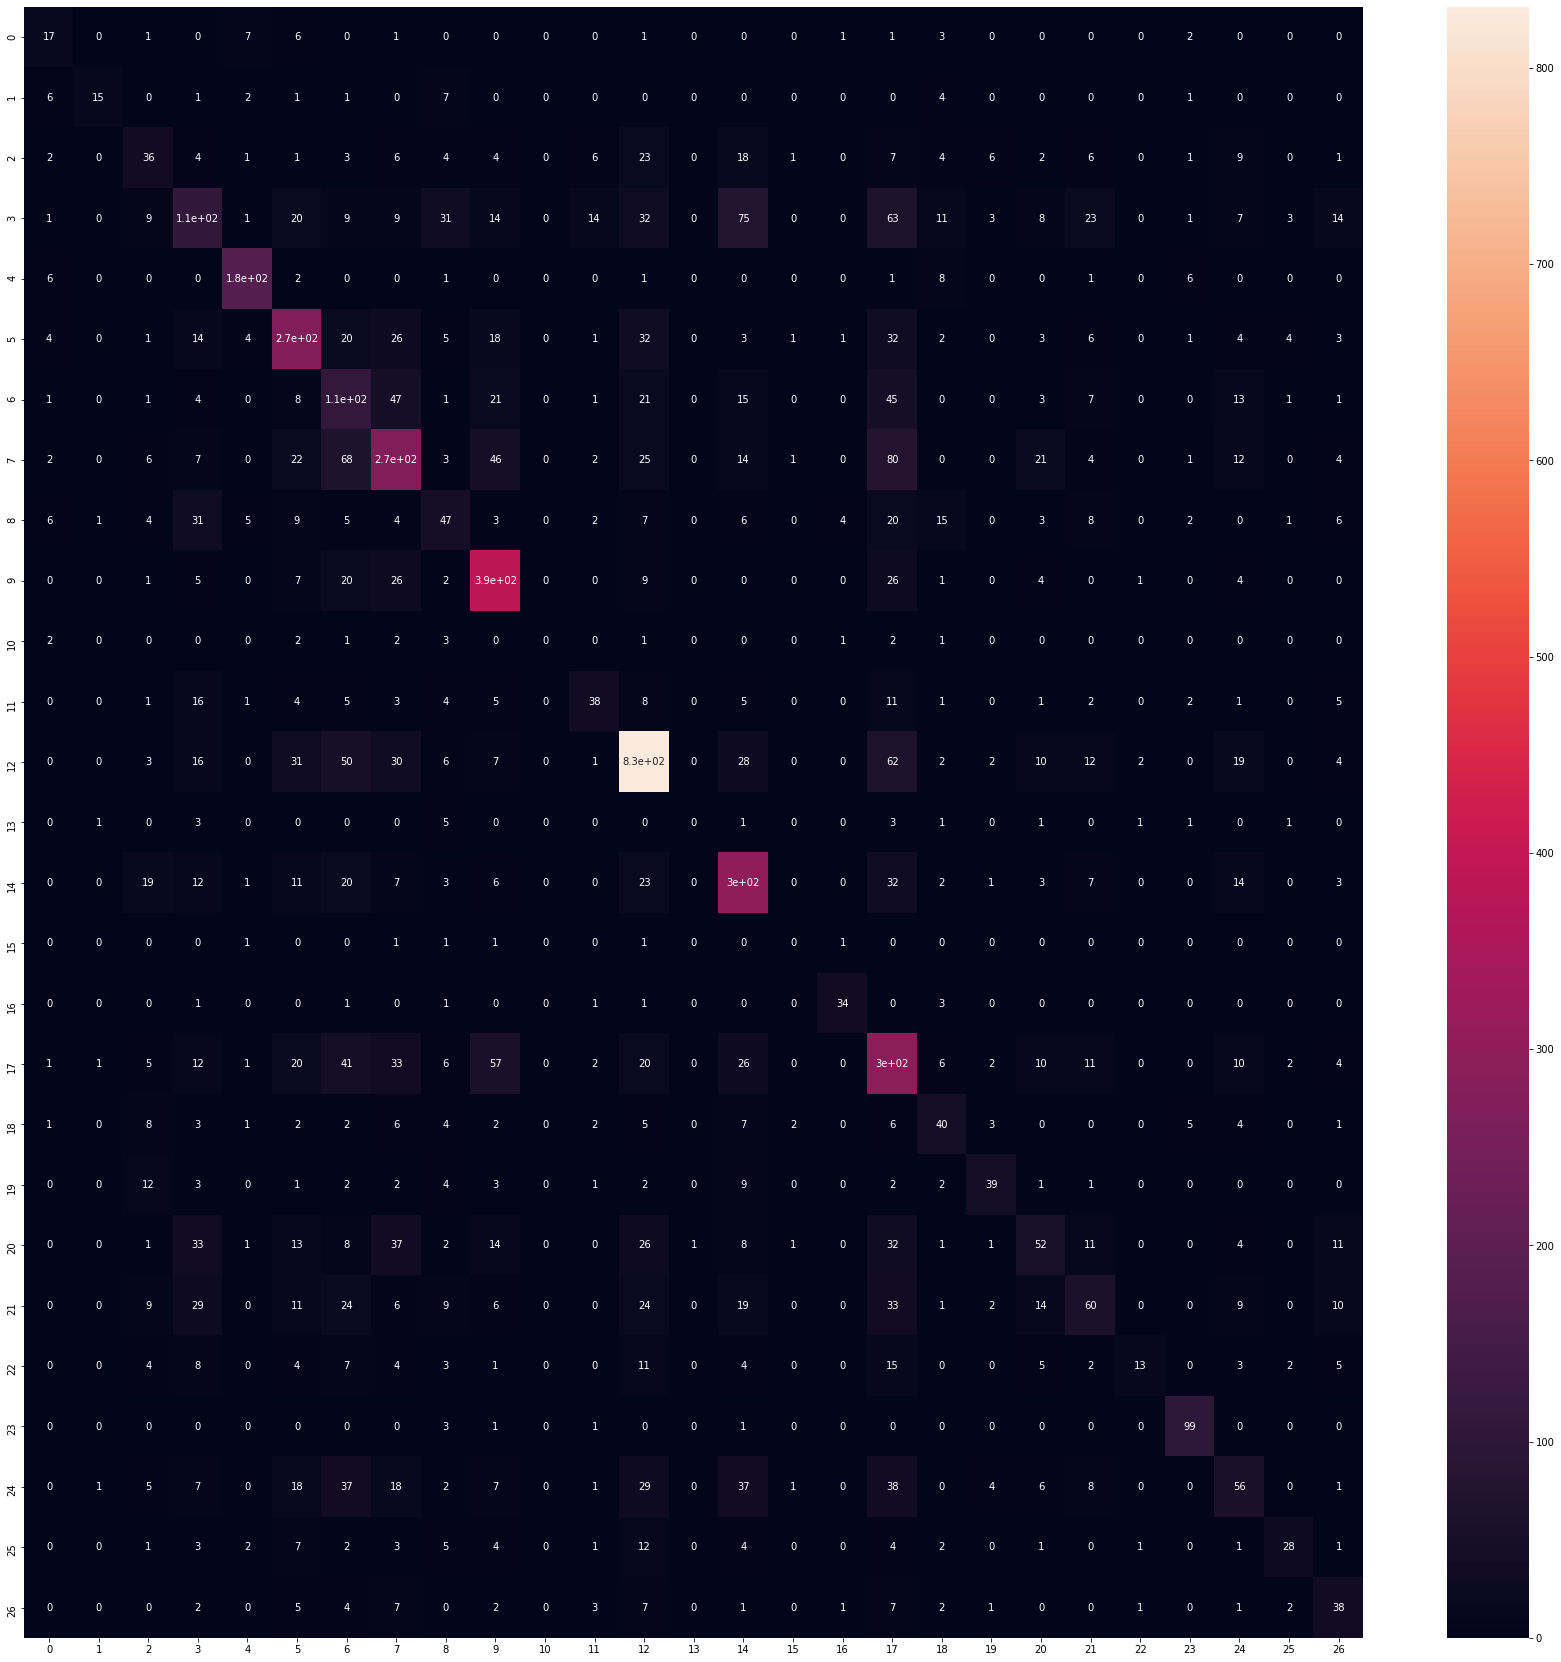

In [59]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_mat, index = [i for i in range(27)],
                                    columns = [i for i in range(27)])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)